In [1]:
import pickle
import numpy as np
import pandas as pd
from imblearn.over_sampling import KMeansSMOTE
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, balanced_accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import glob
import joblib
from collections import Counter

import os
import re
import subprocess
import glob
from git import Repo, Git

from matplotlib import pyplot as plt

Fonction permettant de supprimer des colonnes dans un dataframe Pandas.

In [2]:
def delete_unused_columns(df):
    columns_to_drop = ["name", "followers", "commit_count_a", "source", "job", "name_without_spaces", "from", "to",
                       "project", "index", "AddSM","DelSM","ChurnSM","SumAddDelSM","SumAddDel"]

    for column_to_drop in columns_to_drop:
        if column_to_drop in df.columns :
            df.drop(columns=[column_to_drop], inplace=True)

    df["DiP"] = df["DiP"].round()
    df["DiP"].replace(0, 1, inplace=True)

Fonction permettant d'appliquer un logarithme sur des colonnes d'un dataframe Pandas.

In [3]:
def log_dataframe(df):

    columns_4_log = ["SumAddDelLOC", "DiP", "NoC", "SumAddDelF",
                     "SumAddDelSAM", "AddLOC", "DelLOC", "AddSAM", "DelSAM"]

    for column in columns_4_log:
        df[column] = np.log(df[column] + 1)

Scores the classifier using a k-fold (here a Stratified 4-fold with shuffle)
Synthetic data are created to train the classifier for each fold.
Real data are used to compute measures for the classifier.

## 1) Récupération des métriques de BroadleafCommerce

Nous travaillerons avec les versions majeures et mineures (voir [semantic versioning](https://semver.org/lang/fr/)) du projet BroadleafCommerce disponible sur GitHub : [https://github.com/BroadleafCommerce/BroadleafCommerce](https://github.com/BroadleafCommerce/BroadleafCommerce). Pour cela, nous allons cloner le dépôt puis récupérer les tags des versions et les filtrer par une expression régulière. Puis, pour chacun de ces tags, "checkouter" la version correspondante. Nous lancerons ensuite l'extraction des métriques à l'aide de l'application Java : ck ([https://github.com/mauricioaniche/ck](https://github.com/mauricioaniche/ck)). Cette application créée par Maurício Aniche est dédiée à l'extraction de plusieurs métriques logicielles dont le nombre de lignes de code que nous utiliserons plus tard. 

Dans ce TP, nous allons extraire "manuellement" métriques mais, les plateformes d'intégration continue comme Jenkins ou les outils d'analyse statique comme SonarQube permettent également de calculer des métriques de manière automatique à chaque version releasée ou commitée sur votre système de gestion de versions. 


Pour notre cas d'étude, nous allons : 

1. Utiliser le package GitPython et sa [documentation](https://gitpython.readthedocs.io/en/stable/)) pour :

* Cloner le dépôt Github de BroadleafCommerce à l'endroit indiqué par la variable <code> PATH_TO_REPO </code> à l'aide de la méthode <code> Repo.clone_from </code>
* Créer un objet <code> Repo </code> qui vous permettra de récupérer les tags des versions
* Créer un objet <code> Git </code> qui vous permettra de "checkouter" la version désirée

2. Récupérer la liste des tags du dépôt à l'aide de l'objet <code> Repo </code>.

3. Itérer sur la liste des tags, où pour chaque tag vous allez : 

* Vérifier par une regexp que l'on se situe sur des tags ayant la forme <code> broadleaf-X-Y-0-GA </code> où <code> X </code> et <code> Y </code> peuvent varier entre 0 et 9 et où le tag a une taille fixe (utilisation de ^ et $ pour matérialiser le début et la fin de chaine de caractères)
* Vérifier que l'on ne va pas extraire les métriques d'une version déjà présente dans le dossier <code> ck_metrics </code>
* **/!\ Une fois ces vérifications effectuées,** checkouter la version désirée à l'aide du tag
* Lancer l'extraction des métriques à l'aide de l'instruction python suivante : <code> subprocess.run(["java", "-jar", "ck.jar", ".." + os.sep + "BroadleafCommerce"]) </code>
* Renommer le fichier <code> class.csv </code> en <code> class_[tag].csv </code> et supprimer les fichiers <code> variable.csv, methode.csv, field.csv </code> créés par ck. 

In [4]:
PATH_TO_REPO = "."+os.sep+"BroadleafCommerce"

#Créer les objets Git et repo ici avant l'instruction change directory
if not os.path.isdir(PATH_TO_REPO):
    repo = Repo.clone_from(url="https://github.com/BroadleafCommerce/BroadleafCommerce.git", to_path=PATH_TO_REPO, branch="master")
else:
    repo = Repo(PATH_TO_REPO)

git = Git(PATH_TO_REPO)

wd_notebook = os.getcwd()
os.chdir("." + os.sep + "ck_metrics")

#Placer l'ensemble du code nécessaire à l'extraction ici
tags = []

for tag in repo.tags:
    if re.search("^broadleaf-[0-9].[0-9].0-GA$", str(tag)) and not os.path.exists(f'class_{tag}.csv'):
        repo.git.checkout(tag)
        subprocess.run(["java", "-jar", "ck.jar", ".." + os.sep + "BroadleafCommerce"])
        os.rename('class.csv', f'class_{tag}.csv')
        os.remove('field.csv')
        os.remove('method.csv')
        os.remove('variable.csv')

os.chdir(wd_notebook)

## 2) Utilisation du classifieur de développeurs (Random Forest)
 
Nous allons maintenant utiliser le classifieur de développeurs sauvegardé sous le nom "classifier_rf.pkl". 
Pour cela nous allons charger le classifieur à l'aide de <code> joblib.load </code> ([documentation](https://joblib.readthedocs.io/en/latest/generated/joblib.load.html))

2. Nous allons utiliser les métriques (23) associées à des développeurs, celles-ci sont stockées dans le dossier <code> metrics_by_dev </code>. Chaque fichier de ce dossier est nommé en fonction de la version sur laquelle les métriques ont été extraites. Nous allons donc itérer sur la **liste de ces fichiers ordonnée par ordre alphanumérique**. 

4. Pour chaque fichier CSV, l'ouvrir avec Pandas en tant que Dataframe via la fonction : <code> pd.read_csv </code> ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html))

3. Ces métriques sont à l'état "brut" dans les fichiers, c'est-à-dire qu'elles ont des échelles et des unités différentes. Le classifieur Random Forest que nous avons entrainé lui, ne travaille qu'avec des variables comprises dans [-1;1]. Ici, il va donc falloir faire une mise à l'échelle des variables à l'aide d'un scaler de Scikit-Learn : <code> MinMaxScaler </code> ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)). De plus, afin de réduire les écarts de valeurs sur certaines variables nous allons appliquer un logarithme sur 11 de ces dernières à l'aide de la fonction  <code> log_dataframe </code> de ce Notebook.

5. Prédire ensuite la catégorie des développeurs ("NSSE" ou "SSE") puis la stocker dans le dictionnaire <code> dict_classified_dev </code>. Faire un affichage à l'aide print pour visualiser l'évolution du nombre de dévoloppeurs dans chaque catégorie au fur et à mesure des versions.  


In [5]:
dict_classified_dev = {'SSE' : [], 'NSSE' : []}
list_versions = []

#Placer la suite du code ici
#%%

def addFromDicoToList(dico, prediction, version):
    count_sse_dev = 0
    count_nsse_dev = 0
    for i in range(0, len(prediction)):
        if prediction[i] == "SSE":
            count_sse_dev += 1
        elif prediction[i] == "NSSE":
            count_nsse_dev += 1
    pair_sse = (version.split("-")[1], count_sse_dev)
    pair_nsse = (version.split("-")[1], count_nsse_dev)
    dico["SSE"].append(pair_sse)
    dico["NSSE"].append(pair_nsse)


def orderDico(dico):
    dico["SSE"] = orderTuples(tupleList=dico["SSE"])
    dico["NSSE"] = orderTuples(tupleList=dico["NSSE"])


def orderTuples(tupleList):
    return sorted(tupleList, key=lambda tup: tup[0])

#%%
def printDevs(dico, versions):
    for i in range(0, versions):
        currentdevs = dico["SSE"][i]
        print("Pour la version \"" + str(currentdevs[0]) + "\" :")
        print("Il y a eu " + str(currentdevs[1]) + " développeurs SSE")
        currentdevs = dico["NSSE"][i]
        print("Il y a eu " + str(currentdevs[1]) + " développeurs NSSE\n")

#%%

dict_classified_dev = {'SSE': [], 'NSSE': []}
list_versions = []
classifier = joblib.load("classifier_rf.pkl")
#Placer la suite du code ici
scale = MinMaxScaler(feature_range=(-1, 1))
evolution = {}
versions_count = 0
for file in os.listdir("." + os.sep + "metrics_by_dev"):
    versions_count += 1
    sse_dev = []
    nsse_dev = []
    df = pd.read_csv("." + os.sep + "metrics_by_dev" + os.sep + file)
    delete_unused_columns(df)
    log_dataframe(df)
    df = pd.DataFrame(scale.fit_transform(df.values), columns=df.columns, index=df.index)
    prediction = classifier.predict(df)
    addFromDicoToList(dico=dict_classified_dev, prediction=prediction, version=file.split("_")[1])
orderDico(dico=dict_classified_dev)
printDevs(dico=dict_classified_dev, versions=versions_count)

d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted

Pour la version "1.6.0" :
Il y a eu 1 développeurs SSE
Il y a eu 3 développeurs NSSE

Pour la version "2.0.0" :
Il y a eu 6 développeurs SSE
Il y a eu 2 développeurs NSSE

Pour la version "2.1.0" :
Il y a eu 6 développeurs SSE
Il y a eu 2 développeurs NSSE

Pour la version "2.2.0" :
Il y a eu 7 développeurs SSE
Il y a eu 3 développeurs NSSE

Pour la version "2.3.0" :
Il y a eu 7 développeurs SSE
Il y a eu 3 développeurs NSSE

Pour la version "2.4.0" :
Il y a eu 7 développeurs SSE
Il y a eu 3 développeurs NSSE

Pour la version "3.0.0" :
Il y a eu 7 développeurs SSE
Il y a eu 4 développeurs NSSE

Pour la version "3.1.0" :
Il y a eu 7 développeurs SSE
Il y a eu 9 développeurs NSSE

Pour la version "4.0.0" :
Il y a eu 7 développeurs SSE
Il y a eu 21 développeurs NSSE

Pour la version "4.1.0" :
Il y a eu 8 développeurs SSE
Il y a eu 24 développeurs NSSE

Pour la version "5.0.0" :
Il y a eu 11 développeurs SSE
Il y a eu 21 développeurs NSSE

Pour la version "5.1.0" :
Il y a eu 12 développeur

d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\Documents\Cours\IA pour GL\TP-Master-MTP-GL-IA4GL\venv\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


## 3) Extraction du nombre total de lignes de code depuis les fichiers CSV

Nous avons classé les développeurs par catégorie pour chaque version de BroadleafCommerce. 
L'étape suivante est d'extraire le nombre total de ligne de code pour chaque version de BroadleafCommerce. Pour cela chacun des fichiers triés par ordre alphanumérique croissant doit être ouvert avec Pandas. Vous devez ensuite faire la somme de la colonne "loc" des fichiers et l'ajouter à la liste <code> loc_by_versions </code>.

In [6]:
#Liste où ajouter les loc de chaque version 
loc_by_versions = []

for file in sorted(os.listdir("." + os.sep + "ck_metrics")):
    if file == "ck.jar":
        continue
    nb_codelines = 0
    df = pd.read_csv("." + os.sep + "ck_metrics" + os.sep + file)
    codelines = df["loc"]
    for i in codelines:
        nb_codelines += i
    loc_by_versions.append(nb_codelines)
print(loc_by_versions)

[78450, 77640, 100686, 101778, 105371, 108435, 108459, 92314, 102533, 121023, 127584, 131071, 127385, 134819, 140862, 144383, 150338]


## 4) Tracé du graphique du nombre de développeurs SSE et nombre de lignes de code par version de BroadleafCommerce

L'objectif ici est de tracer à l'aide du package matplotlib ([documentation](https://matplotlib.org/stable/contents.html)) un graphique à 3 axes comme montré dans la figure d'exemple ci-dessous. 

![Évolution du nombre de développeurs SSE vs LOC](plot_sse_vs_loc_by_version.png)

En traçant cette figure vous devriez observer une particularité commune aux deux courbes, faite part de cette observation dans la case textutelle ci-desssous. 

**Observation** : 

NameError: name 'versions' is not defined

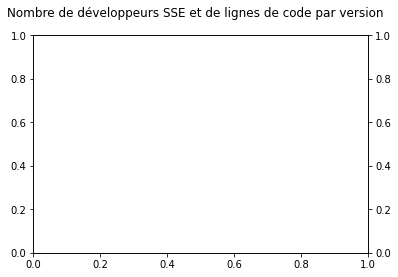

In [7]:
fig, ax1 = plt.subplots()

#Création d'un deuxième axe Y 
ax2 = ax1.twinx()

del loc_by_versions[0]
del loc_by_versions[len(loc_by_versions) - 1]
fig.suptitle("Nombre de développeurs SSE et de lignes de code par version")
ax1.plot(versions, dict_classified_dev["SSE"],'tab:orange')
ax2.plot(versions, loc_by_versions,'tab:green')
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax1.set_ylabel("Nombre de développeurs SSE")
ax2.set_ylabel("Nombre de lignes de codes")
ax2.set_xlabel("Version du projet")
ax1.set_xlabel("Version du projet")
plt.subplots_adjust(bottom=0.15)
plt.show()

## 5) Création d'un estimateur du nombre de développeurs expérimentés en fonction de la taille du projet (LoC)


Nous avons maintenant l'ensemble des données permettant de créer un estimateur du nombre de développeurs expérimentés en fonction du nombre de ligne de code du projet. 
Pour ce faire, nous allons mettre en oeuvre un estimateur basé sur une régression linéaire : <code> LinearRegression </code> ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)). Cet estimateur utilise la méthode des moindres carrés afin d'ajuster une droite d'équation *ax+b+e* où *a* est le coefficient directeur, *b* l'ordonnée à l'origine et *e* l'erreur liée aux moindres carrés. 

Pour cela nous allons : 
1. Créer un objet LinearRegression et l'ajuster sur <code> X </code> et <code> y </code> à l'aide de la méthode <code> fit </code>.
2. Afficher le coefficient de régression sur <code> X </code> et <code> y </code>.
3. Déterminer le coefficient de détermination linéaire avec la fonction <code> r2_score </code> ([documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score)) qui mesure l'ajustement entre les prédiction du classifieur sur les données <code> X </code> par rapport aux sorties <code> y </code>, plus il proche de 1 meilleures sont les prédictions. 
4. Prédire le nombre de développeurs expérimentés SSE pour 150000, 180000 et 200000 lignes de code. 
5. Tracer un graphique semblable à la figure d'exemple ci-desssous :

![](plot_sse_loc_prediction.png)

Les points noirs sont les données déjà connues à savoir le nombre de développeurs expérimentés et le nombre de lignes de code pour chaque version. Les point rouges correspondent aux trois valeurs prédites pour 150000, 180000 et 200000 lignes. La droite bleu est la droite de régression. Pour tracer ce graphique vous pouvez vous inspirer de cet [exemple Scikit-Learn ](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html#sphx-glr-auto-examples-linear-model-plot-ols-py). 

Voilà vous êtes maintenant capable de prédire vos besoins en ressources humaines en fonction de la taille de votre projet :) ! 

In [ ]:
#Valeurs X et y à utiliser pour entrainer et évaluer le régresseur
X = np.array(loc_by_versions).reshape(-1,1)
y = np.array(dict_classified_dev["SSE"])

#PLacer la suite du code ici

---

## Bonus

Jusque là nous avons utilisé un classifieur Random Forest déjà entrainé puis sauvegardé au format Pickle (sérialisation). Dans le bloc de code ci-dessous vous trouverez le code qui a permis la création de ce classifieur. 

Ce code est découpé en plusieurs parties:

* Ouverture du CSV contenant les développeurs et leurs métriques avec Pandas
* Suppresssion des colonnes non utilisées pour la classification
* Transformation des variables (logarithme et mise à l'échelle)
* Création de l'objet permettant de générer des données synthétiques. Les données synthétiques permettent de contrebalancer le fait que nous n'ayons que peu de données dans la classe des développeurs expérimentés. 
* Création du classifieur ici un random forest
* Évaluation du classifieur via 4-fold stratifié ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratifiedkfold#sklearn.model_selection.StratifiedKFold))
* Génération de données synthétiques sur l'ensemble du jeu de données puis entrainement du modèle
* Sauvegarde du modèle au format pickle

Vous pouvez modifier plusieurs choses qui vont influer sur la qualité de votre classifieur :  
- Les variables utilisées. Nous utilisons ici 23 métriques. Vous pouvez en supprimer dans le dataframe Pandas et constater l'effet. 
- Le scaler utilisé, ici un MinMax pour mettre les variables dans l'intervalle [-1,1] ([documentation sur les types de scaler](https://www.datacorner.fr/feature-scaling/))
- Le type de classifieur utilisé (ici Random Forest) et ses paramètres. Vous pouvez choisir un autre classifieur parmis ceux fournis par le package Scikit Learn ([documentation](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py))
- L'utilisation ou non de la génération de données synthétiques. 



 

Returns labels (y)

In [ ]:
def get_labels(df):
    df.loc[df['job'] == "SA", 'job'] = "SSE"
    df.loc[df['job'] != "SSE", 'job'] = "NSSE"

    return df["job"]

Scales data according to the scaler given as input

In [ ]:
def scaling(scaler, X):
    return scaler.fit_transform(X)

Creates synthetic data with original data using smote method.

In [ ]:
def create_synthetic_data(smote, X_scaled, y):
    return smote.fit_resample(X_scaled, y)

Train the classifier with synthetic data an create a classification report on original data

In [ ]:
def train_and_classification_report(classifier, X_synthetic, y_synthetic, X_scaled, y):
    classifier.fit(X_synthetic, y_synthetic)
    print(classification_report(y, classifier.predict(X_scaled)))

In [ ]:
def stratifiedKFold_scoring(classifier, X_scaled, y, smote = None):
    kf = StratifiedKFold(n_splits=4, shuffle=False)#, random_state=0)
    print("===> Start kfold <===")
    scores = {"F1": {"values" : []}, "Recall": {"values" : []},
              "Precision": {"values" : []}, "Balanced\nAccuracy" : {"values" : []}}

    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled, y), 1):
        print("=> Fold : ",fold)
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train = X_scaled[train_index]
        y_train = y[train_index]
        X_test = X_scaled[test_index]
        y_test = y[test_index]

        if smote is not None:
            X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)
            classifier.fit(X_train_synthetic, y_train_synthetic)
        else:
            classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1 = f1_score(y_test, y_pred, pos_label="SSE")
        recall = recall_score(y_test, y_pred, pos_label="SSE")
        precision = precision_score(y_test, y_pred, pos_label="SSE")
        accuracy = balanced_accuracy_score(y_test, y_pred)

        scores["F1"]["values"].append(f1)
        scores["Recall"]["values"].append(recall)
        scores["Precision"]["values"].append(precision)
        scores["Balanced\nAccuracy"]["values"].append(accuracy)

    for key in scores:
        scores[key]["values"] = np.array(scores[key]["values"])
        scores[key]["mean"] = np.mean(scores[key]["values"])
        scores[key]["std"] = np.std(scores[key]["values"])
        scores[key]["ci95"] = np.std(scores[key]["values"]) * 2

        print(key, "mean :%0.4f" % scores[key]["mean"])
        print(key, "std : %0.4f" % scores[key]["std"])
        print(key, "95%% Confidence Interval +/- %0.4f" % (scores[key]["ci95"]))
        print()
    return scores

In [ ]:
df = pd.read_csv("dataset_dev_anonymized.csv")
y = get_labels(df)

delete_unused_columns(df)

log_dataframe(df)
scaler = MinMaxScaler(feature_range=(-1,1))

X = df
X_scaled = scaling(scaler, X)

#Instanciation du générateur de données synthétiques à l'aide de la méthode k-means SMOTE
smote = KMeansSMOTE(sampling_strategy='minority', random_state=9090)
#Création du classifieur RF
classifier = RandomForestClassifier(criterion='gini', max_depth=None, max_features='log2', n_estimators=75, random_state=0)

#Évaluation du classifieur à l'aide d'un 4-fold stratifié
stratifiedKFold_scoring(classifier, X_scaled, y, smote = smote)

#Génération de données synthétiques sur l'ensemble des données
X_synthetic, y_synthetic = smote.fit_resample(X_scaled, y)
#Entrainement du classifieur sur les données synthétiques
classifier.fit(X_synthetic, y_synthetic)
#Sauvegarde du classifieur (sérialisation) 
pickle.dump(classifier, open("classifier_rf.pkl", 'wb'))


===> Start kfold <===
=> Fold :  1
=> Fold :  2
=> Fold :  3
=> Fold :  4
F1 mean :0.7689
F1 std : 0.0263
F1 95% Confidence Interval +/- 0.0525

Recall mean :0.7538
Recall std : 0.0800
Recall 95% Confidence Interval +/- 0.1601

Precision mean :0.7937
Precision std : 0.0414
Precision 95% Confidence Interval +/- 0.0828

Balanced
Accuracy mean :0.8603
Balanced
Accuracy std : 0.0343
Balanced
Accuracy 95% Confidence Interval +/- 0.0687

